# FrontEnd_01

In this notebook I will create/explore how to create the choropleth map that I want to show in my Streamlit app.  
For this purpose I will use **Bokeh**.

This is more of a test/work notebook rather than a finished-code-ready-to-put-in-production.  
I have used this code as a base to create the [Streamlit.ipynb](Streamlit.ipynb).

### 0. [Requirements](#Requirements)

### 1. [Load and process Taxi Zones shape file](#Load-and-process-Taxi-Zones-shape-file)

- [Convert WKT Polygons to X and Y coordinates](#Convert-WKT-Polygons-to-X-and-Y-coordinates)

### 2. [Get Taxis Data from ML model](#Get-Taxis-Data-from-ML-model)

### 3. [Join & Transform Shape data with Taxis data](#Join-&-Transform-Shape-data-with-Taxis-data)

### 4. [Create Choropleth map with Bokeh](#Create-Choropleth-map-with-Bokeh)
#### 4.1 Define Bokeh Elements
- [``ColumnDataSource``](#ColumnDataSource)
- [``ColorMapper``](#ColorMapper)
- [``ColorBar``](#ColorBar)
- [``Figure``](#Figure)
- [Draw taxi zones as ``patches``](#Draw-taxi-zones-as-'Patches')
- [Add ``ColorBar`` to layout](#Add-ColorBar-to-layout)

#### 4.2 Interactivity
- [Add ``HoverTool``](#Add-HoverTool)
- [Add Slider widget for hourly periods](#Add-Slider-widget-for-hourly-periods)
- [Add Radio Buttons for weekdays](#Add-Radio-Buttons-for-weekdays)
- [Add interaction via JavaScript Callback](#Add-interaction-via-JavaScript-Callback)

# Requirements

- Python Shape File library.
- Geopandas.
- Shapely

In [1]:
# !pip install pyshp
# !pip install geopandas
#!pip install shapely

In [2]:
# IMPORTS
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
%matplotlib inline
import random

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Load and process Taxi Zones shape file
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

The shape file is within this folder: ``../data/taxi_zones/taxi_zones.shp``

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,geometry
0,4,0.043567,0.000112,Alphabet City,4,"POLYGON ((-8234500.227 4971984.094, -8234502.1..."
1,12,0.036661,0.000042,Battery Park,12,"POLYGON ((-8239385.311 4968901.615, -8239356.3..."
2,13,0.050281,0.000149,Battery Park City,13,"POLYGON ((-8239027.255 4970990.635, -8239068.9..."
3,24,0.047000,0.000061,Bloomingdale,24,"POLYGON ((-8233137.952 4982697.872, -8233194.5..."
4,41,0.052793,0.000143,Central Harlem,41,"POLYGON ((-8231824.746 4984298.100, -8231526.5..."


Number of Polygons: 69


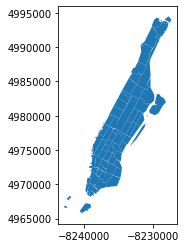

In [3]:
df_shape = gpd.read_file('../data/taxi_zones/taxi_zones.shp')

# filter Manhattan zones
df_shape = df_shape[df_shape['borough'] == 'Manhattan'].reset_index(drop=True)

df_shape = df_shape.drop(['borough'], axis=1)

#EPSG-Code of Web Mercador
df_shape.to_crs(epsg=3785, inplace=True)

display(df_shape.head())
print("Number of Polygons: %d"%len(df_shape))

# Simplify Shape of Zones (otherwise slow peformance of plot)
df_shape["geometry"] = df_shape["geometry"].simplify(100)
                                   
df_shape.plot()

### Convert WKT Polygons to X and Y coordinates
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

I have to convert Well-known Text polygones to X and Y coordinates.  
On the other hand, there are 67 Manhattan zones. Some of them are divided into two or more areas.  
For this reason I have to take into account multipolygons and separate them into individual shapes.

In [4]:
data = []
df_shape2 = df_shape.copy()
for zonename, LocationID, shape in df_shape2[["zone", "LocationID", "geometry"]].values:
    #If shape is polygon, extract X and Y coordinates of boundary line:
    if isinstance(shape, Polygon):
        X, Y = shape.boundary.xy
        X = [int(x) for x in X]
        Y = [int(y) for y in Y]
        data.append([LocationID, zonename, X, Y])
        
    #If shape is Multipolygon, extract X and Y coordinates of each sub-Polygon:
    if isinstance(shape, MultiPolygon):
        for poly in shape:
            X, Y = poly.boundary.xy
            X = [int(x) for x in X]
            Y = [int(y) for y in Y]
            data.append([LocationID, zonename, X, Y])

#Create new DataFrame with X an Y coordinates separated:
df_shape2 = pd.DataFrame(data, columns=["LocationID", "ZoneName", "X", "Y"])
print("Number of Polygons: %d"%len(df_shape2))
display(df_shape2.head())

Number of Polygons: 77


,LocationID,ZoneName,X,Y
0,4,Alphabet City,"[-8234500, -8234690, -8235841, -8235196, -8234...","[4971984, 4970961, 4971345, 4972514, 4972139, ..."
1,12,Battery Park,"[-8239385, -8239229, -8239175, -8239225, -8239...","[4968901, 4968851, 4968359, 4968208, 4968705, ..."
2,13,Battery Park City,"[-8239027, -8239307, -8239625, -8239795, -8239...","[4970990, 4969577, 4968770, 4969086, 4970076, ..."
3,24,Bloomingdale,"[-8233137, -8233194, -8234622, -8234426, -8232...","[4982697, 4982598, 4983379, 4983737, 4982971, ..."
4,41,Central Harlem,"[-8231824, -8231160, -8231269, -8231495, -8231...","[4984298, 4983928, 4983731, 4983733, 4983456, ..."


# Get Data from ML model
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

For the purpose of this notebook (explore/learn how to create the choropleth map) I will use the training dataset. 

In the [``Streamlit.ipynb``](Streamlit.ipynb) notebook I implement a function to take and transform the **predicted data** the way it needs to be plotted.

In [5]:
# 'df_taxis' should be a data frame returned by the ML model
df_taxis = pd.read_csv('../data/Data_Taxis_2019_Cleaned.csv', sep=',',
                      usecols=['hour','dayofweek','LocationID','pickups'])

pickups = df_taxis.groupby(['hour','dayofweek','LocationID']).sum()
print('Imported Predicted Data:', df_taxis.shape)
display(pickups.head())

Imported Predicted Data: (532407, 4)


pickups
hour dayofweek LocationID         
0    0         4               408
               12               26
               13              400
               24              429
               41              860

# Join & Transform Shape data with Taxis data
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>


This step is necessary to give shape to the DataFrame so that it can be plotted.

In [6]:
##### RUN THIS CELL ONLY ONCE. SHAPE SHOULD BE (77, 172)

#pickups = pd.DataFrame(pickups)
df_taxizones = df_shape2
for hour in range(24):    
    for dayofweek in range(7):
        
        #Get pickups and dropoff for this hour and weekday:
        p = pd.DataFrame(pickups.loc[(hour, dayofweek)]).reset_index().rename(columns={"LocationID" : "LocationID"})
       
        #Add information of pickups and dropoff to the New York Taxi Zone DataFrame:
        df_taxizones = pd.merge(df_taxizones, p, on="LocationID", how="left").fillna(0)
        df_taxizones.rename(columns={"pickups" : "Passenger_%d_%d"%(dayofweek, hour)}, inplace=True) 
        
print('Processed Data for Plot Input: ',df_taxizones.shape)
df_taxizones.head(2)

Processed Data for Plot Input:  (77, 172)


,LocationID,ZoneName,X,Y,Passenger_0_0,Passenger_1_0,Passenger_2_0,Passenger_3_0,Passenger_4_0,Passenger_5_0,Passenger_6_0,Passenger_0_1,Passenger_1_1,Passenger_2_1,Passenger_3_1,Passenger_4_1,Passenger_5_1,Passenger_6_1,Passenger_0_2,Passenger_1_2,Passenger_2_2,Passenger_3_2,Passenger_4_2,Passenger_5_2,Passenger_6_2,Passenger_0_3,Passenger_1_3,Passenger_2_3,Passenger_3_3,Passenger_4_3,Passenger_5_3,Passenger_6_3,Passenger_0_4,Passenger_1_4,Passenger_2_4,Passenger_3_4,Passenger_4_4,Passenger_5_4,Passenger_6_4,Passenger_0_5,Passenger_1_5,Passenger_2_5,Passenger_3_5,Passenger_4_5,Passenger_5_5,Passenger_6_5,Passenger_0_6,Passenger_1_6,Passenger_2_6,Passenger_3_6,Passenger_4_6,Passenger_5_6,Passenger_6_6,Passenger_0_7,Passenger_1_7,Passenger_2_7,Passenger_3_7,Passenger_4_7,Passenger_5_7,Passenger_6_7,Passenger_0_8,Passenger_1_8,Passenger_2_8,Passenger_3_8,Passenger_4_8,Passenger_5_8,Passenger_6_8,Passenger_0_9,Passenger_1_9,Passenger_2_9,Passenger_3_9,Passenger_4_9,Passenger_5_9,Passenger_6_9,Passenger_0_10,Passenger_1_10,Passenger_2_10,Passenger_3_10,Passenger_4_10,Passenger_5_10,Passenger_6_10,Passenger_0_11,Passenger_1_11,Passenger_2_11,Passenger_3_11,Passenger_4_11,Passenger_5_11,Passenger_6_11,Passenger_0_12,Passenger_1_12,Passenger_2_12,Passenger_3_12,Passenger_4_12,Passenger_5_12,Passenger_6_12,Passenger_0_13,Passenger_1_13,Passenger_2_13,Passenger_3_13,Passenger_4_13,Passenger_5_13,Passenger_6_13,Passenger_0_14,Passenger_1_14,Passenger_2_14,Passenger_3_14,Passenger_4_14,Passenger_5_14,Passenger_6_14,Passenger_0_15,Passenger_1_15,Passenger_2_15,Passenger_3_15,Passenger_4_15,Passenger_5_15,Passenger_6_15,Passenger_0_16,Passenger_1_16,Passenger_2_16,Passenger_3_16,Passenger_4_16,Passenger_5_16,Passenger_6_16,Passenger_0_17,Passenger_1_17,Passenger_2_17,Passenger_3_17,Passenger_4_17,Passenger_5_17,Passenger_6_17,Passenger_0_18,Passenger_1_18,Passenger_2_18,Passenger_3_18,Passenger_4_18,Passenger_5_18,Passenger_6_18,Passenger_0_19,Passenger_1_19,Passenger_2_19,Passenger_3_19,Passenger_4_19,Passenger_5_19,Passenger_6_19,Passenger_0_20,Passenger_1_20,Passenger_2_20,Passenger_3_20,Passenger_4_20,Passenger_5_20,Passenger_6_20,Passenger_0_21,Passenger_1_21,Passenger_2_21,Passenger_3_21,Passenger_4_21,Passenger_5_21,Passenger_6_21,Passenger_0_22,Passenger_1_22,Passenger_2_22,Passenger_3_22,Passenger_4_22,Passenger_5_22,Passenger_6_22,Passenger_0_23,Passenger_1_23,Passenger_2_23,Passenger_3_23,Passenger_4_23,Passenger_5_23,Passenger_6_23
0,4,Alphabet City,"[-8234500, -8234690, -8235841, -8235196, -8234...","[4971984, 4970961, 4971345, 4972514, 4972139, ...",408.0,419.0,501.0,696.0,1168.0,3322.0,3877.0,230.0,370.0,342.0,519.0,832.0,3748.0,4640.0,159.0,281.0,178.0,228.0,531.0,3239.0,3860.0,94.0,170.0,159.0,151.0,300.0,1870.0,2461.0,149.0,168.0,125.0,189.0,242.0,958.0,1075.0,150.0,176.0,151.0,210.0,185.0,319.0,292.0,348.0,344.0,369.0,353.0,474.0,389.0,257.0,655.0,732.0,836.0,804.0,830.0,504.0,318.0,1142.0,1187.0,1349.0,1360.0,1359.0,651.0,453.0,945.0,1081.0,1111.0,1206.0,1149.0,787.0,592.0,635.0,771.0,715.0,729.0,828.0,930.0,747.0,556.0,573.0,648.0,607.0,682.0,819.0,771.0,459.0,594.0,533.0,599.0,682.0,909.0,782.0,511.0,608.0,542.0,556.0,641.0,961.0,760.0,496.0,561.0,532.0,567.0,772.0,806.0,786.0,448.0,504.0,476.0,554.0,735.0,826.0,827.0,401.0,438.0,431.0,498.0,622.0,792.0,750.0,484.0,580.0,580.0,670.0,779.0,1030.0,787.0,583.0,655.0,712.0,943.0,1109.0,1192.0,791.0,571.0,742.0,750.0,867.0,1131.0,1318.0,671.0,533.0,722.0,736.0,941.0,1162.0,1344.0,678.0,513.0,831.0,914.0,1272.0,1442.0,1495.0,590.0,566.0,805.0,1053.0,1479.0,1753.0,1886.0,686.0,454.0,663.0,920.0,1429.0,2466.0,2850.0,578.0
1,12,Battery Park,"[-8239385, -8239229, -8239175, -8239225, -8239...","[4968901, 4968851, 4968359, 4968208, 4968705, ...",26.0,27.0,57.0,41.0,60.0,104.0,121.0,7.0,11.0,22.0,21.0,32.0,47.0,40.0,3.0,9.0,4.0,8.0,17.0,33.0,32.0,1.0,2.0,2.0,2.0,3.0,9.0,7.0,6.0,4.0,3.0,6.0,4.0,7.0,4.0,17.0,10.0,9.0,11.0,30.0,7.0,3.0,18.0,22.0,20.0,30.0,25.0,12.0,9.0,47.0,54.0,57.0

# Create Choropleth map with Bokeh
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

In [7]:
from bokeh.io import output_notebook, output_file, show
from bokeh.plotting import figure
from bokeh.models import HoverTool, Select, ColumnDataSource, WheelZoomTool, LogColorMapper, LinearColorMapper, ColorBar,BasicTicker
from bokeh.palettes import Viridis256 as palette
output_notebook()

Loading BokehJS ...

## Define Bokeh Elements

### ColumnDataSource
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

``ColumnDataSource`` transforms the data into something that Bokeh and Java understand.

In [8]:
df_taxizones["Passengers"] = df_taxizones["Passenger_0_7"]

source = ColumnDataSource(df_taxizones)

### ColorMapper
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

Y calculate the maximum number of passengers and then use this number to map the colors.

In [9]:
# Calculate max of passengers
max_passengers_per_hour = df_taxizones[filter(lambda x: "Passenger_" in x, df_taxizones.columns)].max().max()

color_mapper = LinearColorMapper(palette=palette[::-1], high=max_passengers_per_hour, low=0)

### ColorBar
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

In [10]:
##### Color Bar
color_bar = ColorBar(color_mapper = color_mapper,
                     ticker = BasicTicker(),
                    label_standoff=8,
                     location=(0,0),
                     orientation='vertical')

### Figure
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

In [11]:
p = figure(title="New York Taxi Pickups",
           plot_width=450, plot_height=750,
           toolbar_location=None,
           tools='pan,wheel_zoom,box_zoom,reset,save')
p.xaxis.visible = False
p.yaxis.visible = False

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Get rid of zoom on axes:
for t in p.tools:
    if type(t) == WheelZoomTool:
        t.zoom_on_axis = False

### Draw taxi zones as 'Patches'
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

In [12]:
patches = p.patches(xs="X", ys="Y", source=source, fill_alpha=1,
                  fill_color={'field': 'Passengers', 'transform': color_mapper},
                  line_color="black", alpha=0.5)
show(p)

### Add ``ColorBar`` to layout
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

In [13]:
p.add_layout(color_bar, 'right')

## Interactivity

### Add ``HoverTool``
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

NOTE: use @ to access the attributes to show.

In [14]:
hovertool = HoverTool(tooltips=[('Zone:', "@ZoneName"),
                                ("Passengers:", "@Passengers")])
p.add_tools(hovertool)
show(p)

### Add Slider widget for hourly periods
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

In [15]:
from bokeh.models.widgets import Slider, RadioButtonGroup
from bokeh.layouts import column, row, widgetbox

slider = Slider(start=0, end=23, value=7, step=1, title="Hour", width=600)

show(slider)

### Add Radio Buttons for weekdays
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

In [16]:
radiobuttons_weekday = RadioButtonGroup(
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    active=0,
    width=400)

layout_widgets = column(slider, row(radiobuttons_weekday))
show(layout_widgets)

### Add interaction via JavaScript Callback
<div style = "float:right"><a style="text-decoration:none" href = "#FrontEnd_01">Up</a></div>

NOTE: I won´t need to use this callback with Streamlit, but at the time I did this, I didn´t know.

In [17]:
from bokeh.models.callbacks import CustomJS

#Define callback-function with JavaScript Code:
callback = CustomJS(args=dict(p=p, source=source, slider=slider,
                             radiobuttons_weekday=radiobuttons_weekday),
                    code="""
                    
//Get value of slider for hour:
var hour = slider.value;

//Get value of weekday:
var weekday = radiobuttons_weekday.active;

//Change data of "Passengers" column in data source to passenger data of the selected hour:
source.data["Passengers"] = source.data["Passenger_" + weekday + "_" + hour];
source.change.emit();
                    
                    """)

#Bind Callback to value change of slider and radiobuttons:
slider.js_on_change("value", callback)
radiobuttons_weekday.js_on_change("active", callback)

#Show all elements:
layout = column(layout_widgets, p)
show(layout)

## Reminder
This is not final code, it is useful code that I have adapted to the Streamlit app.  
Go to notebook [Streamlit.ipynb](Streamlit.ipynb) to see the evolution.